In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('/Users/marywu/Desktop/Desktop - mary/open your eyes./Northwestern/357/US_Elections_2024/cleaned_data.csv')

In [23]:
electoral_vote_counts = {
    'Alabama': 9, 'Alaska': 3, 'Arizona': 11, 'Arkansas': 6, 'California': 54,
    'Colorado': 10, 'Connecticut': 7, 'Delaware': 3, 'District of Columbia': 3,
    'Florida': 30, 'Georgia': 16, 'Hawaii': 4, 'Idaho': 4, 'Illinois': 19,
    'Indiana': 11, 'Iowa': 6, 'Kansas': 6, 'Kentucky': 8, 'Louisiana': 8,
    'Maine': 4, 'Maine Cd 1': 1, 'Maine Cd 2': 1, 'Maryland': 10, 'Massachusetts': 11,
    'Michigan': 15, 'Minnesota': 10, 'Mississippi': 6, 'Missouri': 10,
    'Montana': 4, 'Nebraska': 5, 'Nebraska Cd 1': 1, 'Nebraska Cd 2': 1, 'Nebraska Cd 3': 1,
    'Nevada': 6, 'New Hampshire': 4, 'New Jersey': 14, 'New Mexico': 5, 'New York': 28,
    'North Carolina': 16, 'North Dakota': 3, 'Ohio': 17, 'Oklahoma': 7, 'Oregon': 8,
    'Pennsylvania': 19, 'Rhode Island': 4, 'South Carolina': 9, 'South Dakota': 3,
    'Tennessee': 11, 'Texas': 40, 'Utah': 6, 'Vermont': 3, 'Virginia': 13,
    'Washington': 12, 'West Virginia': 4, 'Wisconsin': 10, 'Wyoming': 3
}

In [51]:
n_draws = 5000

win_probabilities = {}

for index, row in data.iterrows():
    state = row['state']
    harris_pct = row['Harris'] / 100
    trump_pct = row['Trump'] / 100
    other_pct = row['Other']

    posterior_params = np.array([1 + harris_pct * 500, 1 + trump_pct * 500, 1 + other_pct * 500])

    samples = np.random.dirichlet(posterior_params, n_draws)

    harris_wins = np.mean(samples[:, 0] > samples[:, 1])
    
    win_probabilities[state] = harris_wins

print(win_probabilities)

{'Alaska': 0.0124, 'Arizona': 0.2492, 'Arkansas': 0.0002, 'California': 1.0, 'Colorado': 0.994, 'Connecticut': 1.0, 'Delaware': 1.0, 'Florida': 0.3274, 'Georgia': 0.2034, 'Illinois': 1.0, 'Indiana': 0.0112, 'Iowa': 0.1794, 'Kansas': 0.1266, 'Maine': 1.0, 'Maine CD-1': 1.0, 'Maine CD-2': 0.0184, 'Maryland': 1.0, 'Massachusetts': 1.0, 'Michigan': 0.5022, 'Minnesota': 0.8832, 'Missouri': 0.0046, 'Montana': 0.0, 'Nebraska': 0.0, 'Nebraska CD-1': 0.0342, 'Nebraska CD-2': 0.88, 'Nebraska CD-3': 0.0, 'Nevada': 0.4108, 'New Hampshire': 0.9488, 'New Jersey': 0.9996, 'New Mexico': 0.9832, 'New York': 1.0, 'North Carolina': 0.5052, 'North Dakota': 0.0066, 'Ohio': 0.0528, 'Oklahoma': 0.0, 'Oregon': 0.881, 'Pennsylvania': 0.6782, 'Rhode Island': 1.0, 'South Carolina': 0.012, 'South Dakota': 0.0, 'Tennessee': 0.0, 'Texas': 0.1156, 'Utah': 0.0, 'Vermont': 1.0, 'Virginia': 0.9946, 'Washington': 1.0, 'West Virginia': 0.0, 'Wisconsin': 0.8208}


In [52]:
# Aggregate district results for Maine and Nebraska
def aggregate_districts(state_name, districts, data, ev_counts, n_draws=5000):
    harris_total = sum(data.loc[data['state'] == district, 'Harris'].values[0] * ev_counts[district] for district in districts)
    trump_total = sum(data.loc[data['state'] == district, 'Trump'].values[0] * ev_counts[district] for district in districts)
    other_total = sum(data.loc[data['state'] == district, 'Other'].values[0] * ev_counts[district] for district in districts)
    total_ev = sum(ev_counts[district] for district in districts)

    harris_pct = harris_total / total_ev
    trump_pct = trump_total / total_ev
    other_pct = other_total / total_ev

    posterior_params = np.array([1 + harris_pct * 500, 1 + trump_pct * 500, 1 + other_pct * 500])

    samples = np.random.dirichlet(posterior_params, n_draws)
    harris_win_prob = np.mean(samples[:, 0] > samples[:, 1])

    return {
        'State': state_name,
        'Harris %': harris_pct,
        'Trump %': trump_pct,
        'P(Harris wins)': harris_win_prob,
        'EV': total_ev
    }

In [53]:
electoral_vote_counts.update({
    'Maine': 2,        
    'Maine CD-1': 1,   
    'Maine CD-2': 1,   
    'Nebraska': 2,     
    'Nebraska CD-1': 1,
    'Nebraska CD-2': 1,
    'Nebraska CD-3': 1 
})

maine_aggregated = aggregate_districts('Maine', ['Maine', 'Maine CD-1', 'Maine CD-2'], data, electoral_vote_counts)
nebraska_aggregated = aggregate_districts('Nebraska', ['Nebraska', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3'], data, electoral_vote_counts)

aggregated_results_df = pd.DataFrame([maine_aggregated, nebraska_aggregated])
aggregated_results_df

,State,Harris %,Trump %,P(Harris wins),EV
0,Maine,48.0,41.0,1.0,4
1,Nebraska,41.0,53.8,0.0,5


In [54]:
# Update aggregated Maine and Nebraska results to win_probabilities
districts_to_remove = ['Maine CD-1', 'Maine CD-2', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3']
for district in districts_to_remove:
    win_probabilities.pop(district, None)

win_probabilities['Maine'] = maine_aggregated['P(Harris wins)']
win_probabilities['Nebraska'] = nebraska_aggregated['P(Harris wins)']

# Manually add states that have no public Harris-Trump Polls
missing_probabilities = {
    'Alabama': 0.02,          
    'District of Columbia': 0.98, 
    'Hawaii': 0.98,   
    'Idaho': 0.02,
    'Kentucky': 0.02,
    'Louisiana': 0.02,
    'Mississippi': 0.02,
    'Wyoming': 0.02   
}

win_probabilities.update(missing_probabilities)

win_probabilities = dict(sorted(win_probabilities.items()))
print(win_probabilities)

{'Alabama': 0.02, 'Alaska': 0.0124, 'Arizona': 0.2492, 'Arkansas': 0.0002, 'California': 1.0, 'Colorado': 0.994, 'Connecticut': 1.0, 'Delaware': 1.0, 'District of Columbia': 0.98, 'Florida': 0.3274, 'Georgia': 0.2034, 'Hawaii': 0.98, 'Idaho': 0.02, 'Illinois': 1.0, 'Indiana': 0.0112, 'Iowa': 0.1794, 'Kansas': 0.1266, 'Kentucky': 0.02, 'Louisiana': 0.02, 'Maine': 1.0, 'Maryland': 1.0, 'Massachusetts': 1.0, 'Michigan': 0.5022, 'Minnesota': 0.8832, 'Mississippi': 0.02, 'Missouri': 0.0046, 'Montana': 0.0, 'Nebraska': 0.0, 'Nevada': 0.4108, 'New Hampshire': 0.9488, 'New Jersey': 0.9996, 'New Mexico': 0.9832, 'New York': 1.0, 'North Carolina': 0.5052, 'North Dakota': 0.0066, 'Ohio': 0.0528, 'Oklahoma': 0.0, 'Oregon': 0.881, 'Pennsylvania': 0.6782, 'Rhode Island': 1.0, 'South Carolina': 0.012, 'South Dakota': 0.0, 'Tennessee': 0.0, 'Texas': 0.1156, 'Utah': 0.0, 'Vermont': 1.0, 'Virginia': 0.9946, 'Washington': 1.0, 'West Virginia': 0.0, 'Wisconsin': 0.8208, 'Wyoming': 0.02}


In [55]:
# Summary table
summary_table_final = pd.DataFrame({
    'State': sorted(win_probabilities.keys()),                   # List of states sorted alphabetically
    'Harris %': [data.loc[data['state'] == state, 'Harris'].mean() for state in sorted(win_probabilities.keys())],
    'Trump %': [data.loc[data['state'] == state, 'Trump'].mean() for state in sorted(win_probabilities.keys())],
    'P(Harris wins)': [win_probabilities[state] for state in sorted(win_probabilities.keys())],
    'EV': [electoral_vote_counts.get(state, 0) for state in sorted(win_probabilities.keys())]
})

summary_table_final['Harris %'] = summary_table_final['Harris %'].round(1)
summary_table_final['Trump %'] = summary_table_final['Trump %'].round(1)
summary_table_final['P(Harris wins)'] = summary_table_final['P(Harris wins)'].round(3)
summary_table_final.index += 1

# Display table
from IPython.display import display
display(summary_table_final)

,State,Harris %,Trump %,P(Harris wins),EV
1,Alabama,NaN,NaN,0.020,9
2,Alaska,43.3,51.4,0.012,3
3,Arizona,46.7,47.8,0.249,11
4,Arkansas,40.0,55.0,0.000,6
5,California,60.4,35.0,1.000,54
6,Colorado,54.8,41.4,0.994,10
7,Connecticut,53.0,37.0,1.000,7
8,Delaware,54.8,36.4,1.000,3
9,District of Columbia,NaN,NaN,0.980,3
10,Florida,44.9,50.6,0.327,30


Harris wins 70.12 times out 100, and Trump wins 29.88 times out of 100.


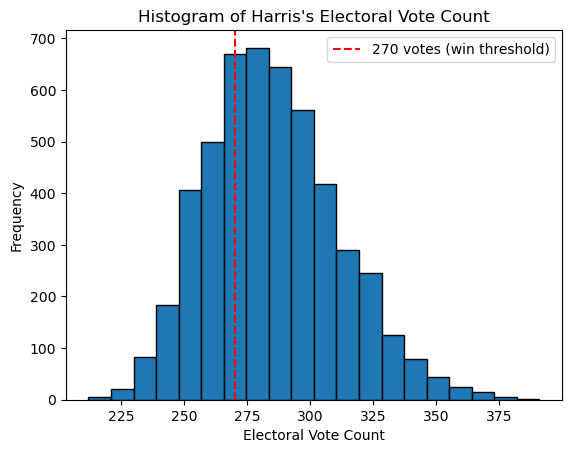

In [56]:
# Simulate the election
n_simulations = 5000
harris_electoral_counts = np.zeros(n_simulations)

for i in range(n_simulations):
    harris_total = 0
    for state, prob_harris_wins in win_probabilities.items():
        # Simulate a biased coin flip
        if np.random.rand() < prob_harris_wins:
            harris_total += electoral_vote_counts.get(state, 0)
    harris_electoral_counts[i] = harris_total

harris_wins_count = np.sum(harris_electoral_counts >= 270)
trump_wins_count = n_simulations - harris_wins_count 

harris_win = (harris_wins_count / n_simulations) * 100
trump_win = (trump_wins_count / n_simulations) * 100

print(f"Harris wins {harris_win:.2f} times out 100, and Trump wins {trump_win:.2f} times out of 100.")

# Plotting
plt.hist(harris_electoral_counts, bins=20, edgecolor='black')
plt.title("Histogram of Harris's Electoral Vote Count")
plt.xlabel("Electoral Vote Count")
plt.ylabel("Frequency")
plt.axvline(x=270, color='red', linestyle='--', label='270 votes (win threshold)')
plt.legend()
plt.show()

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the re-uploaded dataset
clean_data = pd.read_csv('/Users/marywu/Desktop/Desktop - mary/open your eyes./Northwestern/357/US_Elections_2024/cleaned_data.csv')

# Convert the date column to datetime to ensure sorting by recency
clean_data['end_date'] = pd.to_datetime(clean_data['end_date'])

# Step 1: Filter for the most recent poll in each state
latest_polls = clean_data.sort_values(by='end_date').groupby('state').tail(1)

# Define the sample size to convert percentages to counts for Dirichlet parameters
sample_size = 500

# Dictionary to store win probabilities based on the most recent poll data
win_probabilities = {}

# Iterate over each state in the latest polls data
for index, row in latest_polls.iterrows():
    state = row['state']
    harris_pct = row['Harris']
    trump_pct = row['Trump']
    other_pct = row['Other']
    
    # Convert percentages to counts for Dirichlet parameters
    harris_count = harris_pct * sample_size / 100
    trump_count = trump_pct * sample_size / 100
    other_count = other_pct * sample_size / 100
    
    # Define Dirichlet parameters with a vague prior
    dirichlet_params = [1 + harris_count, 1 + trump_count, 1 + other_count]
    
    # Draw samples from the Dirichlet distribution
    n_draws = 5000
    samples = np.random.dirichlet(dirichlet_params, n_draws)
    
    # Calculate the probability that Harris wins (p_M > p_O)
    harris_win_prob = np.mean(samples[:, 0] > samples[:, 1])
    
    # Store the result in the dictionary
    win_probabilities[state] = harris_win_prob

# Step 2: Add missing probabilities for states without polling data
missing_probabilities = {
    'Alabama': 0.02,
    'District of Columbia': 0.98,
    'Hawaii': 0.98,
    'Idaho': 0.02,
    'Kentucky': 0.02,
    'Louisiana': 0.02,
    'Mississippi': 0.02,
    'Wyoming': 0.02
}
win_probabilities.update(missing_probabilities)

# Step 3: Aggregate Maine and Nebraska results
def aggregate_districts_to_state(state_name, districts, data, ev_counts):
    # Weighted averages of Harris, Trump, and Other polling data based on electoral votes
    harris_total = sum(data.loc[data['state'] == district, 'Harris'].values[0] * ev_counts[district] for district in districts)
    trump_total = sum(data.loc[data['state'] == district, 'Trump'].values[0] * ev_counts[district] for district in districts)
    other_total = sum(data.loc[data['state'] == district, 'Other'].values[0] * ev_counts[district] for district in districts)
    total_ev = sum(ev_counts[district] for district in districts)

    harris_pct = harris_total / total_ev
    trump_pct = trump_total / total_ev
    other_pct = other_total / total_ev

    # Dirichlet posterior sampling
    dirichlet_params = [1 + harris_pct * sample_size / 100, 1 + trump_pct * sample_size / 100, 1 + other_pct * sample_size / 100]
    samples = np.random.dirichlet(dirichlet_params, n_draws)
    harris_win_prob = np.mean(samples[:, 0] > samples[:, 1])
    
    return harris_win_prob

# Define electoral votes and districts for Maine and Nebraska
electoral_vote_counts = {
    'Maine': 2, 'Maine CD-1': 1, 'Maine CD-2': 1,
    'Nebraska': 2, 'Nebraska CD-1': 1, 'Nebraska CD-2': 1, 'Nebraska CD-3': 1
}

# Calculate aggregated win probabilities for Maine and Nebraska
win_probabilities['Maine'] = aggregate_districts_to_state('Maine', ['Maine', 'Maine CD-1', 'Maine CD-2'], clean_data, electoral_vote_counts)
win_probabilities['Nebraska'] = aggregate_districts_to_state('Nebraska', ['Nebraska', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3'], clean_data, electoral_vote_counts)

# Remove individual district entries
for district in ['Maine CD-1', 'Maine CD-2', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3']:
    win_probabilities.pop(district, None)

win_probabilities['Maine'] = maine_aggregated['P(Harris wins)']
win_probabilities['Nebraska'] = nebraska_aggregated['P(Harris wins)']

# Manually add states that have no public Harris-Trump Polls
missing_probabilities = {
    'Alabama': 0.02,          
    'District of Columbia': 0.98, 
    'Hawaii': 0.98,   
    'Idaho': 0.02,
    'Kentucky': 0.02,
    'Louisiana': 0.02,
    'Mississippi': 0.02,
    'Wyoming': 0.02   
}

win_probabilities.update(missing_probabilities)

win_probabilities = dict(sorted(win_probabilities.items()))
print(win_probabilities)

{'Alabama': 0.02, 'Alaska': 0.0224, 'Arizona': 0.1926, 'Arkansas': 0.0004, 'California': 1.0, 'Colorado': 1.0, 'Connecticut': 1.0, 'Delaware': 1.0, 'District of Columbia': 0.98, 'Florida': 0.0224, 'Georgia': 0.2212, 'Hawaii': 0.98, 'Idaho': 0.02, 'Illinois': 1.0, 'Indiana': 0.0002, 'Iowa': 0.0682, 'Kansas': 0.0068, 'Kentucky': 0.02, 'Louisiana': 0.02, 'Maine': 1.0, 'Maryland': 1.0, 'Massachusetts': 1.0, 'Michigan': 0.3886, 'Minnesota': 0.9616, 'Mississippi': 0.02, 'Missouri': 0.0004, 'Montana': 0.0, 'Nebraska': 0.0, 'Nevada': 0.4312, 'New Hampshire': 0.4652, 'New Jersey': 0.998, 'New Mexico': 0.9832, 'New York': 1.0, 'North Carolina': 0.5374, 'North Dakota': 0.0, 'Ohio': 0.083, 'Oklahoma': 0.0, 'Oregon': 0.9974, 'Pennsylvania': 0.2838, 'Rhode Island': 1.0, 'South Carolina': 0.0, 'South Dakota': 0.0, 'Tennessee': 0.0, 'Texas': 0.0326, 'Utah': 0.0, 'Vermont': 1.0, 'Virginia': 0.9604, 'Washington': 1.0, 'West Virginia': 0.0, 'Wisconsin': 0.497, 'Wyoming': 0.02}


In [64]:
electoral_vote_counts = {
    'Alabama': 9, 'Alaska': 3, 'Arizona': 11, 'Arkansas': 6, 'California': 54,
    'Colorado': 10, 'Connecticut': 7, 'Delaware': 3, 'District of Columbia': 3,
    'Florida': 30, 'Georgia': 16, 'Hawaii': 4, 'Idaho': 4, 'Illinois': 19,
    'Indiana': 11, 'Iowa': 6, 'Kansas': 6, 'Kentucky': 8, 'Louisiana': 8,
    'Maine': 4, 'Maine Cd 1': 1, 'Maine Cd 2': 1, 'Maryland': 10, 'Massachusetts': 11,
    'Michigan': 15, 'Minnesota': 10, 'Mississippi': 6, 'Missouri': 10,
    'Montana': 4, 'Nebraska': 5, 'Nebraska Cd 1': 1, 'Nebraska Cd 2': 1, 'Nebraska Cd 3': 1,
    'Nevada': 6, 'New Hampshire': 4, 'New Jersey': 14, 'New Mexico': 5, 'New York': 28,
    'North Carolina': 16, 'North Dakota': 3, 'Ohio': 17, 'Oklahoma': 7, 'Oregon': 8,
    'Pennsylvania': 19, 'Rhode Island': 4, 'South Carolina': 9, 'South Dakota': 3,
    'Tennessee': 11, 'Texas': 40, 'Utah': 6, 'Vermont': 3, 'Virginia': 13,
    'Washington': 12, 'West Virginia': 4, 'Wisconsin': 10, 'Wyoming': 3
}

In [65]:
# Create a summary table using the latest polling data and manually assigned probabilities
summary_table_final = pd.DataFrame({
    'State': sorted(win_probabilities.keys()),                   # List of states sorted alphabetically
    'Harris %': [latest_polls.loc[latest_polls['state'] == state, 'Harris'].mean() if state in latest_polls['state'].values else np.nan for state in sorted(win_probabilities.keys())],
    'Trump %': [latest_polls.loc[latest_polls['state'] == state, 'Trump'].mean() if state in latest_polls['state'].values else np.nan for state in sorted(win_probabilities.keys())],
    'P(Harris wins)': [win_probabilities[state] for state in sorted(win_probabilities.keys())],
    'EV': [electoral_vote_counts.get(state, 0) for state in sorted(win_probabilities.keys())]
})

# Round the percentage columns and probability column for readability
summary_table_final['Harris %'] = summary_table_final['Harris %'].round(1)
summary_table_final['Trump %'] = summary_table_final['Trump %'].round(1)
summary_table_final['P(Harris wins)'] = summary_table_final['P(Harris wins)'].round(3)

# Set index to start at 1 for a cleaner presentation
summary_table_final.index += 1

# Display table
from IPython.display import display
display(summary_table_final)

,State,Harris %,Trump %,P(Harris wins),EV
1,Alabama,NaN,NaN,0.020,9
2,Alaska,44.0,53.0,0.022,3
3,Arizona,46.8,50.7,0.193,11
4,Arkansas,40.0,55.0,0.000,6
5,California,62.8,37.2,1.000,54
6,Colorado,58.7,41.3,1.000,10
7,Connecticut,53.0,37.0,1.000,7
8,Delaware,54.0,37.0,1.000,3
9,District of Columbia,NaN,NaN,0.980,3
10,Florida,44.0,53.0,0.022,30


Harris wins 30.20 times out 100, and Trump wins 69.80 times out of 100.


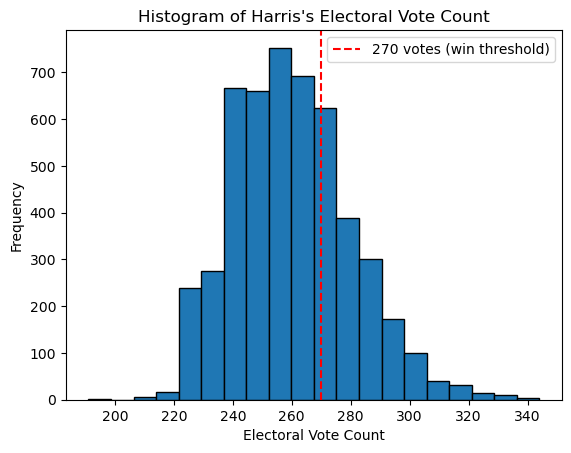

In [66]:
# Simulate the election
n_simulations = 5000
harris_electoral_counts = np.zeros(n_simulations)

for i in range(n_simulations):
    harris_total = 0
    for state, prob_harris_wins in win_probabilities.items():
        # Simulate a biased coin flip
        if np.random.rand() < prob_harris_wins:
            harris_total += electoral_vote_counts.get(state, 0)
    harris_electoral_counts[i] = harris_total

harris_wins_count = np.sum(harris_electoral_counts >= 270)
trump_wins_count = n_simulations - harris_wins_count 

harris_win = (harris_wins_count / n_simulations) * 100
trump_win = (trump_wins_count / n_simulations) * 100

print(f"Harris wins {harris_win:.2f} times out 100, and Trump wins {trump_win:.2f} times out of 100.")

# Plotting
plt.hist(harris_electoral_counts, bins=20, edgecolor='black')
plt.title("Histogram of Harris's Electoral Vote Count")
plt.xlabel("Electoral Vote Count")
plt.ylabel("Frequency")
plt.axvline(x=270, color='red', linestyle='--', label='270 votes (win threshold)')
plt.legend()
plt.show()